# Tarea calificada 3 INAR_2021

## Cat vs. Dog Image Classification

Este ejercicio consiste en desarrollar un modelo deep learning CNN (aunque eres libre de probar otras alternativas) para una dataset que contiene imágenes de perros y gatos (exclusivamente). 

Se debe entregar este notebook (como mínimo, se pueden entregar varios notebooks en un .zip) con los siguientes puntos:

1. Carga y pre-proceso de ficheros de datos. (**YA DESARROLLADO, SOLO DEBE SER EJECUTADO**)
2. Configura un (uno al menos) modelo CNN para la clasificación perro versus gato.
3. Realiza el entrenamiento y prueba el rendimiento del modelo con el conjunto de test.

El dataset y la primera parte de este notebook están obtenidos, con infinitas gracias, de

https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb

Por tanto se debe mencionar la siguiente licencia:

#### Copyright 2018 Google LLC.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License.

You may obtain a copy of the License at

 https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and limitations under the License.


## 1. Carga y Pre-Proceso de Datos

Descarga por favor el .zip 

cats_and_dogs_filtered.zip

del Blackboard de la tarea en la misma ruta (carpeta) de este notebook y ejecuta los siguientes pasos.

(o si usas Google Colab lo tienes en la dirección anterior)

Mantengo la nota original del origen del dataset.


**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [47]:
import os
import zipfile

local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp')

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [48]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [49]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.896.jpg', 'cat.897.jpg', 'cat.898.jpg', 'cat.899.jpg', 'cat.900.jpg', 'cat.901.jpg', 'cat.902.jpg', 'cat.903.jpg', 'cat.904.jpg', 'cat.905.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [50]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [51]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

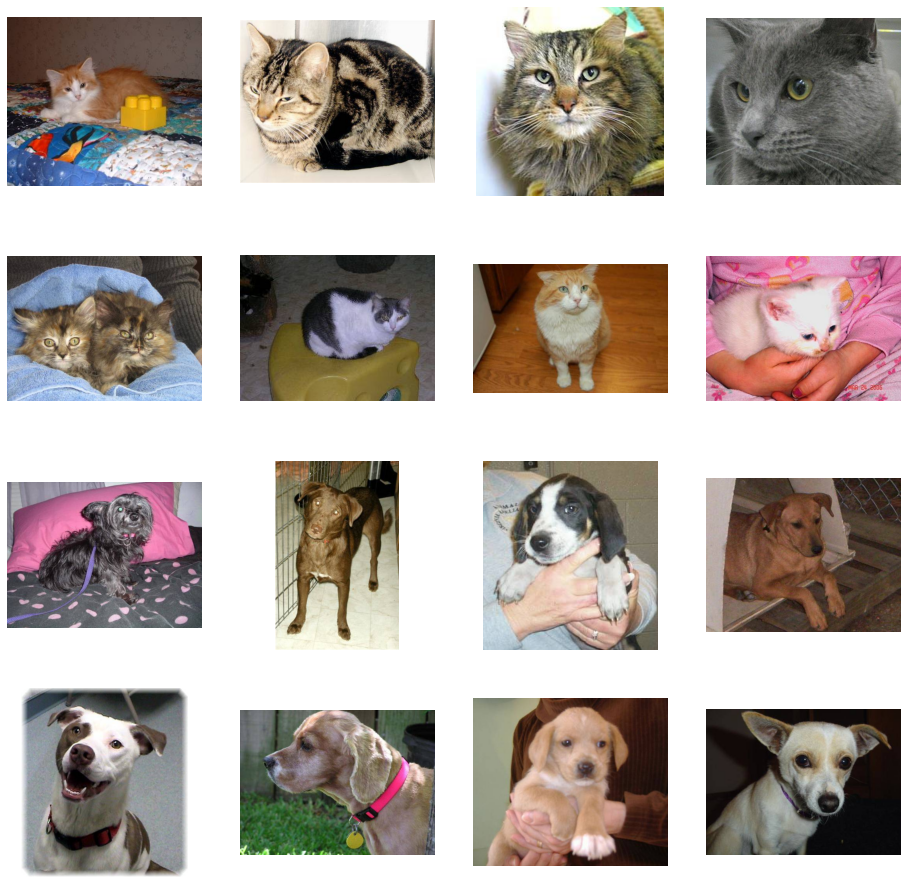

In [52]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 2. Modelo CNN (con summary + compile)

In [54]:
import tensorflow as tf

# Initializing CNN model
model = tf.keras.models.Sequential([# Create model
    
    # Add Model Layers
    # Layer 1
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)), # Convolutional Layer
    tf.keras.layers.MaxPooling2D(2,2), # Pooling Layer
    
    # Layer 2
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), # Convolutional Layer
    tf.keras.layers.MaxPooling2D(2,2), # Pooling Layer
    
    # Layer 3
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), # Convolutional Layer
    tf.keras.layers.MaxPooling2D(2,2), # Pooling Layer
    
    tf.keras.layers.Flatten(), # Converts 3D feature maps to 1D feature vectors
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [55]:
# Analysing model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 64)      

### **Compiling the model**

In [56]:
from tensorflow.keras.optimizers import Adam

# Compile CNN model using accuracy to measure model performance
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

# 3. Entrenamiento del modelo (.fit) y rendimiento del modelo (accuracy) con conjunto test

### **Training the classifier**

In [57]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_steps=50)

Epoch 1/50
100/100 [==============================] - 36s 355ms/step - loss: 0.7320 - accuracy: 0.5365 - val_loss: 0.6729 - val_accuracy: 0.6110
Epoch 2/50
100/100 [==============================] - 35s 349ms/step - loss: 0.6528 - accuracy: 0.6315 - val_loss: 0.6190 - val_accuracy: 0.6860
Epoch 3/50
100/100 [==============================] - 36s 362ms/step - loss: 0.5538 - accuracy: 0.7200 - val_loss: 0.6379 - val_accuracy: 0.6500
Epoch 4/50
100/100 [==============================] - 37s 374ms/step - loss: 0.4651 - accuracy: 0.7805 - val_loss: 0.6188 - val_accuracy: 0.6900
Epoch 5/50
100/100 [==============================] - 37s 375ms/step - loss: 0.3754 - accuracy: 0.8365 - val_loss: 0.6377 - val_accuracy: 0.6940
Epoch 6/50
100/100 [==============================] - 38s 384ms/step - loss: 0.2673 - accuracy: 0.8815 - val_loss: 0.6913 - val_accuracy: 0.7100
Epoch 7/50
100/100 [==============================] - 38s 381ms/step - loss: 0.1963 - accuracy: 0.9170 - val_loss: 0.8599 - val_ac

# **Test with new images**

### **Test Dog**

Sif21.jpg is a dog !


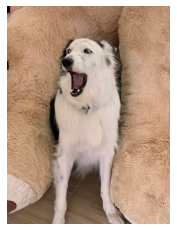

In [61]:
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# Predict new dogs images
path_img_test_dog = os.path.join(os.getcwd(), 'test/dogs/Sif21.jpg') # Path of test dog image 

img_dog = load_img(path_img_test_dog, target_size=(150,150)) # PIL image

x_dog = img_to_array(img_dog) # Numpy array with shape (3,150,150)

x_dog = np.expand_dims(x_dog, axis=0) # Numpy array with shape (1, 3, 150, 150)

images_dog = np.vstack([x_dog]) # Stack x_dog

classes_dog = model.predict(images_dog, batch_size=10) # Make prediction 

name_image = os.path.split(path_img_test_dog)[-1] # Get image name

img = mpimg.imread(path_img_test_dog) # Load image pixels

imgplot = plt.imshow(img) # Plot raw pixel data

plt.axis('off') # Desactive image axis 

if classes_dog[0][0]>0.5: # > 0.5 = dog | < 0.5 = cat
    print(name_image + " is a dog !")
else:
    print(name_image + " is a cat !")

### **Test Cat**

IMG20201002164910.jpg is a cat !


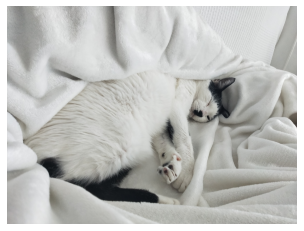

In [62]:
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# Predict new cats images
path_img_test_cat = os.path.join(os.getcwd(), 'test/cats/IMG20201002164910.jpg') # Path of test cat image 

img_cat = load_img(path_img_test_cat, target_size=(150,150)) # PIL image

x_cat = img_to_array(img_cat) # Numpy array with shape (3,150,150)

x_cat = np.expand_dims(x_cat, axis=0) # Numpy array with shape (1, 3, 150, 150)

images_cat = np.vstack([x_cat]) # Stack x_cat

classes_cat = model.predict(images_cat, batch_size=10) # Make prediction 

name_image = os.path.split(path_img_test_cat)[-1] # Get image name

img = mpimg.imread(path_img_test_cat) # Load image pixels

imgplot = plt.imshow(img) # Plot raw pixel data

plt.axis('off') # Desactive image axis

if classes_cat[0][0]>0.5: # > 0.5 = dog | < 0.5 = cat
    print(name_image + " is a dog !")
else:
    print(name_image + " is a cat !")

### **Visualize training results**

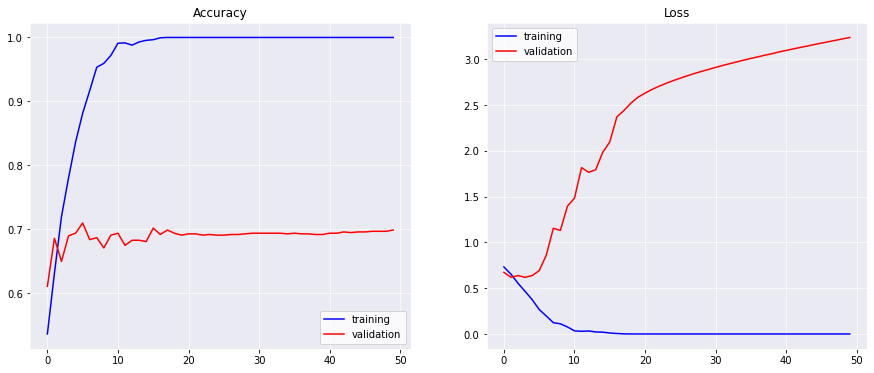

In [64]:
acc      = history.history['accuracy'] # Get values of accuracy during the train
val_acc  = history.history['val_accuracy'] # Get values of val_accuracy during the train
loss     = history.history['loss'] # Get values of loss during the train
val_loss = history.history['val_loss'] # Get values of val_loss during the train
epochs   = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=False)
ax[0].plot(epochs, acc,
          color='b',
          label='training')
ax[0].plot(epochs, val_acc,
          color='r',
          label='validation')
ax[0].set_title('Accuracy')
ax[0].grid(which='both', alpha=0.8, c='white')
ax[0].set_facecolor('#eaeaf2')
ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('white')
ax[0].spines['right'].set_color('white')
ax[0].spines['left'].set_color('white')
ax[0].legend()
ax[1].plot(epochs, loss,
          color='b',
          label='training')
ax[1].plot(epochs, val_loss,
          color='r',
          label='validation')
ax[1].set_title('Loss')
ax[1].grid(which='both', alpha=0.8, c='white')
ax[1].set_facecolor('#eaeaf2')
ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('white')
ax[1].spines['right'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[1].legend()

plt.show()